# Nit diffusion notebook

## Imports

In [56]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from dataset.radardata import *
from dataset.utils import *
from torch import einsum
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Config

In [57]:
config = SimpleNamespace(
    snr = 10,
    cnr = 15,
    batch_size = 16,
    num_samples=50960,
    time_emb_dim = 256,
    noise_scheduler = "linear",
    noise_steps = 1000,
    beta_start = 1e-4,
    beta_end = 0.02,
    
)

## Dataset prep

In [58]:
def prep_data(args):
    train_dataset_with_targets = RadarDataset(num_samples=config.num_samples, n_targets=8, random_n_targets=True, snr=config.snr, cnr=config.cnr)
    train_dataset_without_targets = RadarDataset(num_samples=config.num_samples//10, n_targets=0, random_n_targets=False, snr=config.snr, cnr=config.cnr)
    full_train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_without_targets])
    val_dataset_with_targets = RadarDataset(num_samples=config.num_samples//10, n_targets=8, random_n_targets=True, snr=config.snr, cnr=config.cnr)
    val_dataset_without_targets = RadarDataset(num_samples=config.num_samples//100, n_targets=0, random_n_targets=False, snr=config.snr, cnr=config.cnr)
    full_val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_without_targets])
    train_loader = DataLoader(full_train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(full_val_dataset, batch_size=config.batch_size, shuffle=False)
    signal_mean, signal_std, IQ_mean, IQ_std = get_mean_std(train_loader)
    norm_train_dataset = normalize_and_cache_dataset(full_train_dataset, signal_mean, signal_std, IQ_mean, IQ_std)
    norm_val_dataset = normalize_and_cache_dataset(full_val_dataset, signal_mean, signal_std, IQ_mean, IQ_std)
    norm_train_loader = DataLoader(norm_train_dataset, batch_size=config.batch_size, shuffle=True)
    norm_val_loader = DataLoader(norm_val_dataset, batch_size=config.batch_size, shuffle=False)
    return train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset

In [59]:
train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset = prep_data(config)

Normalizing dataset: 100%|██████████| 5605/5605 [00:06<00:00, 924.25it/s] 


SCNR (dB): tensor(-5.1352)


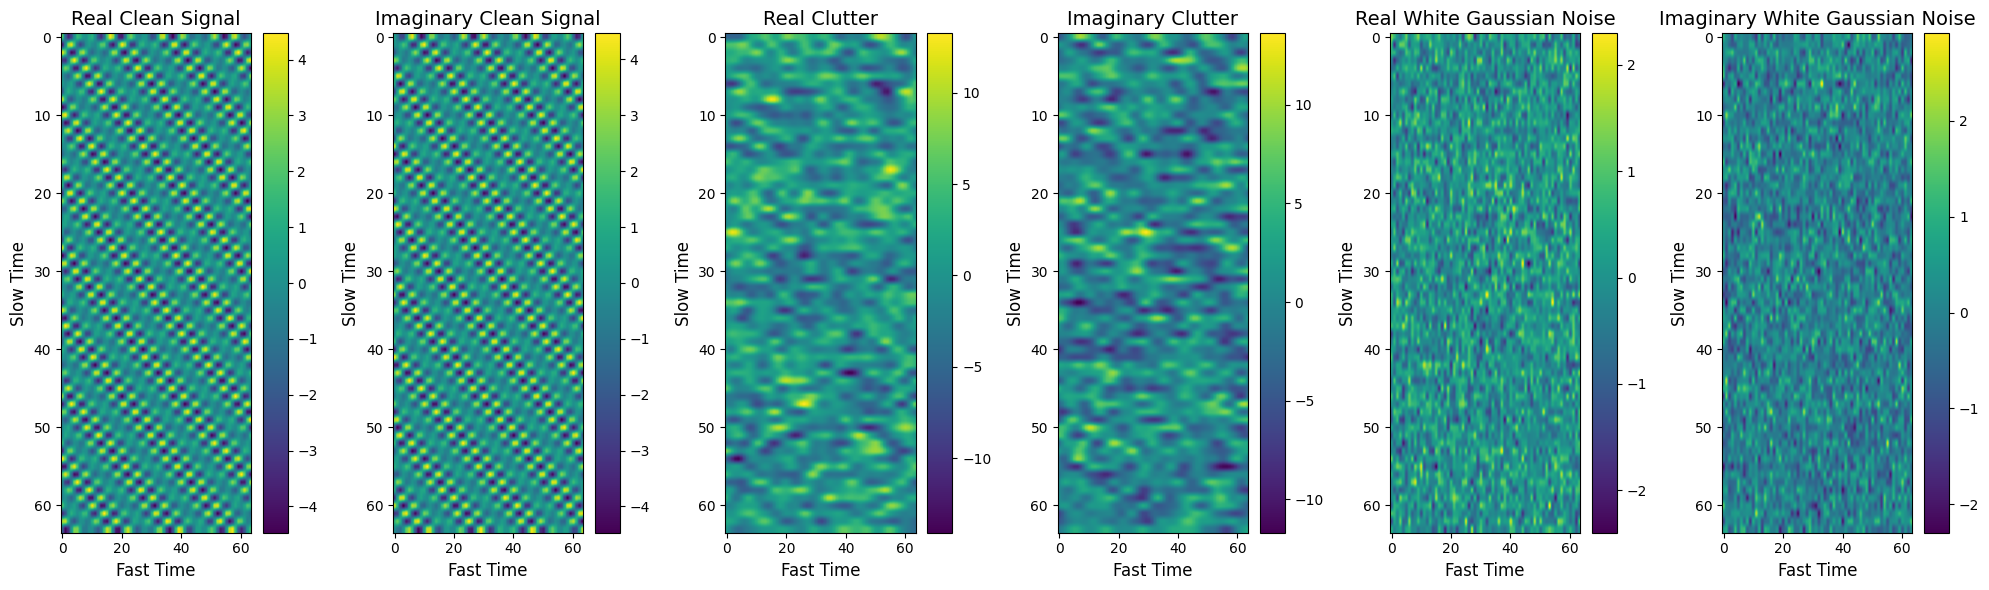

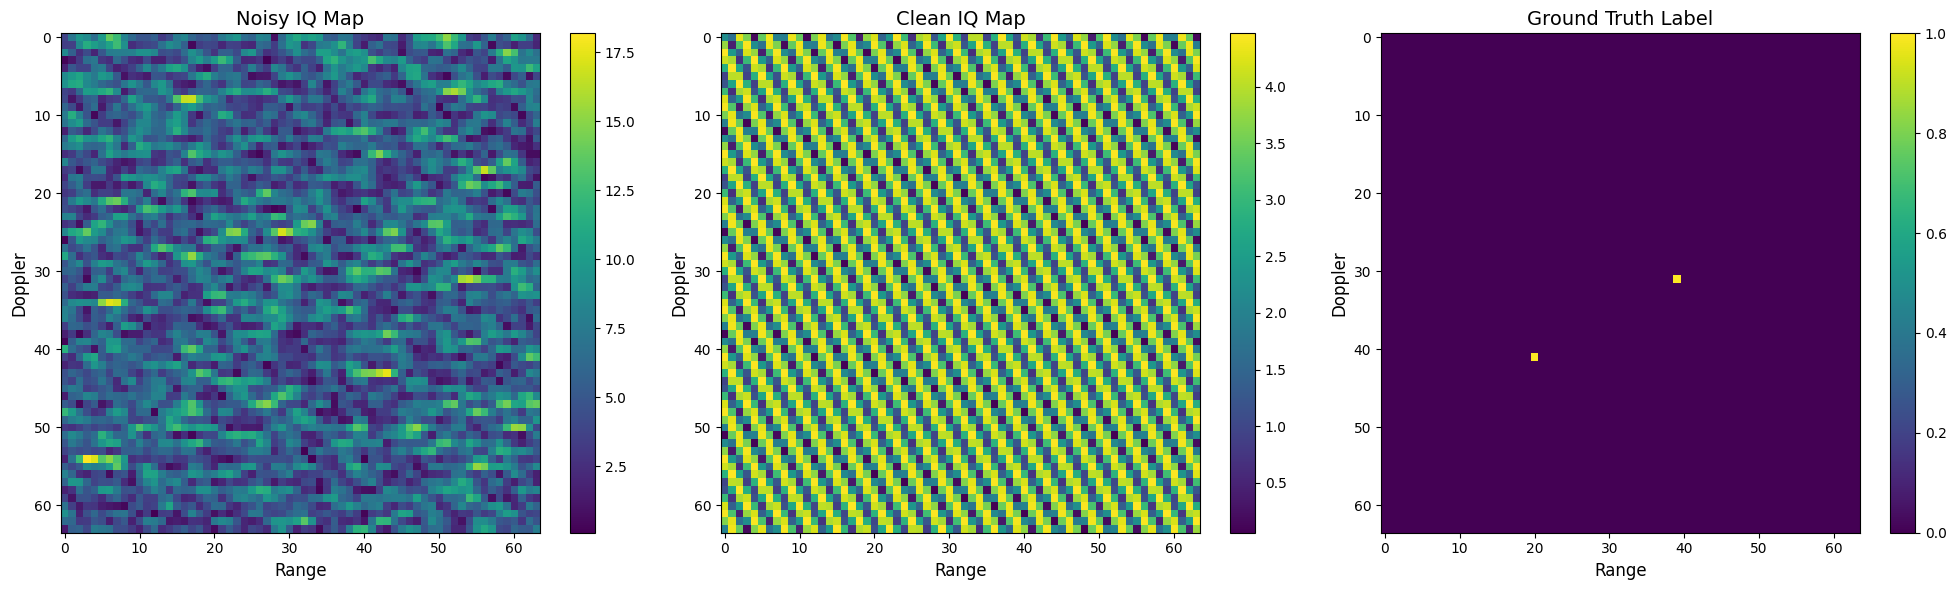

SCNR (dB): tensor(-5.1352)


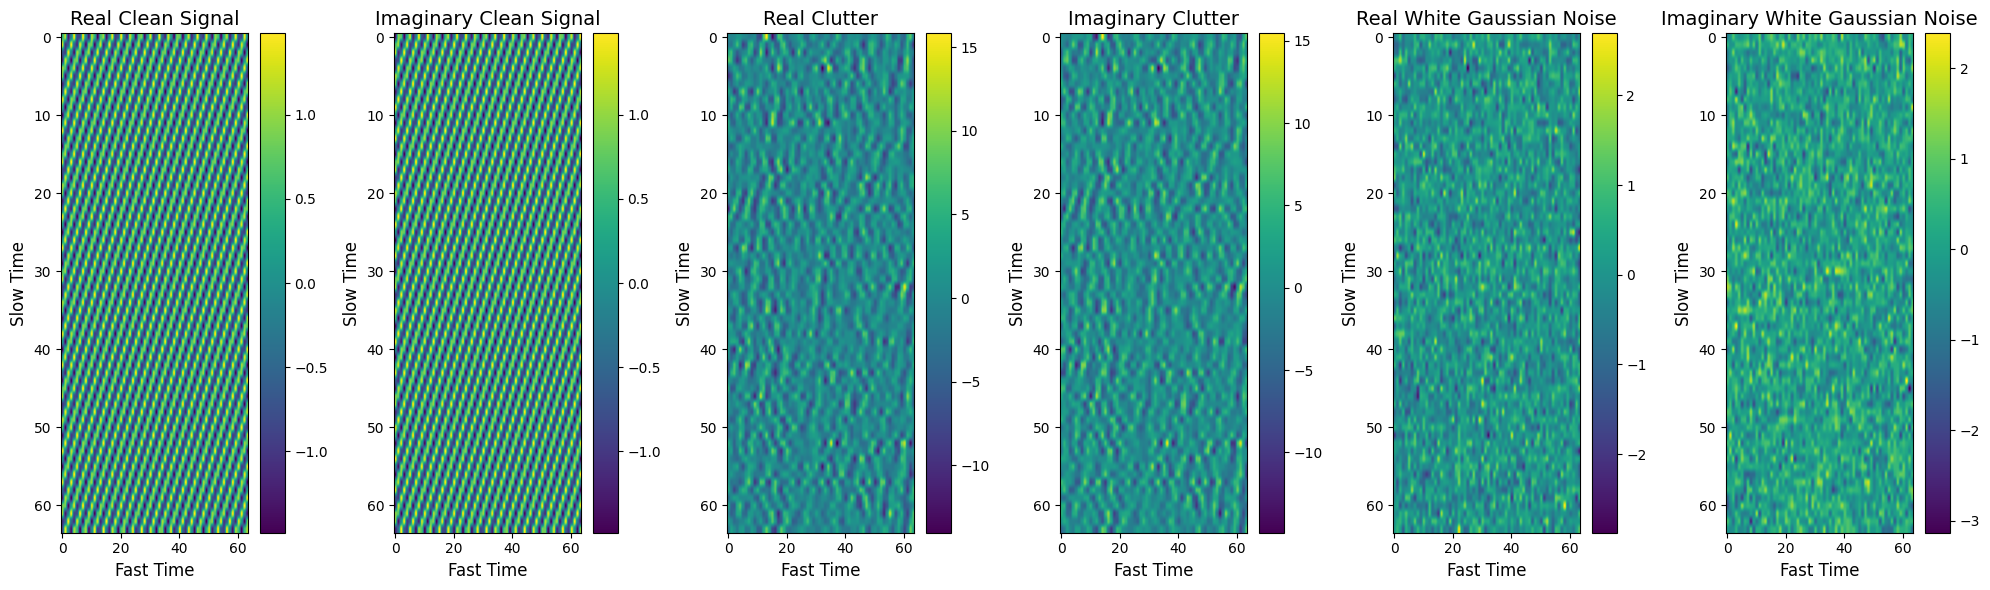

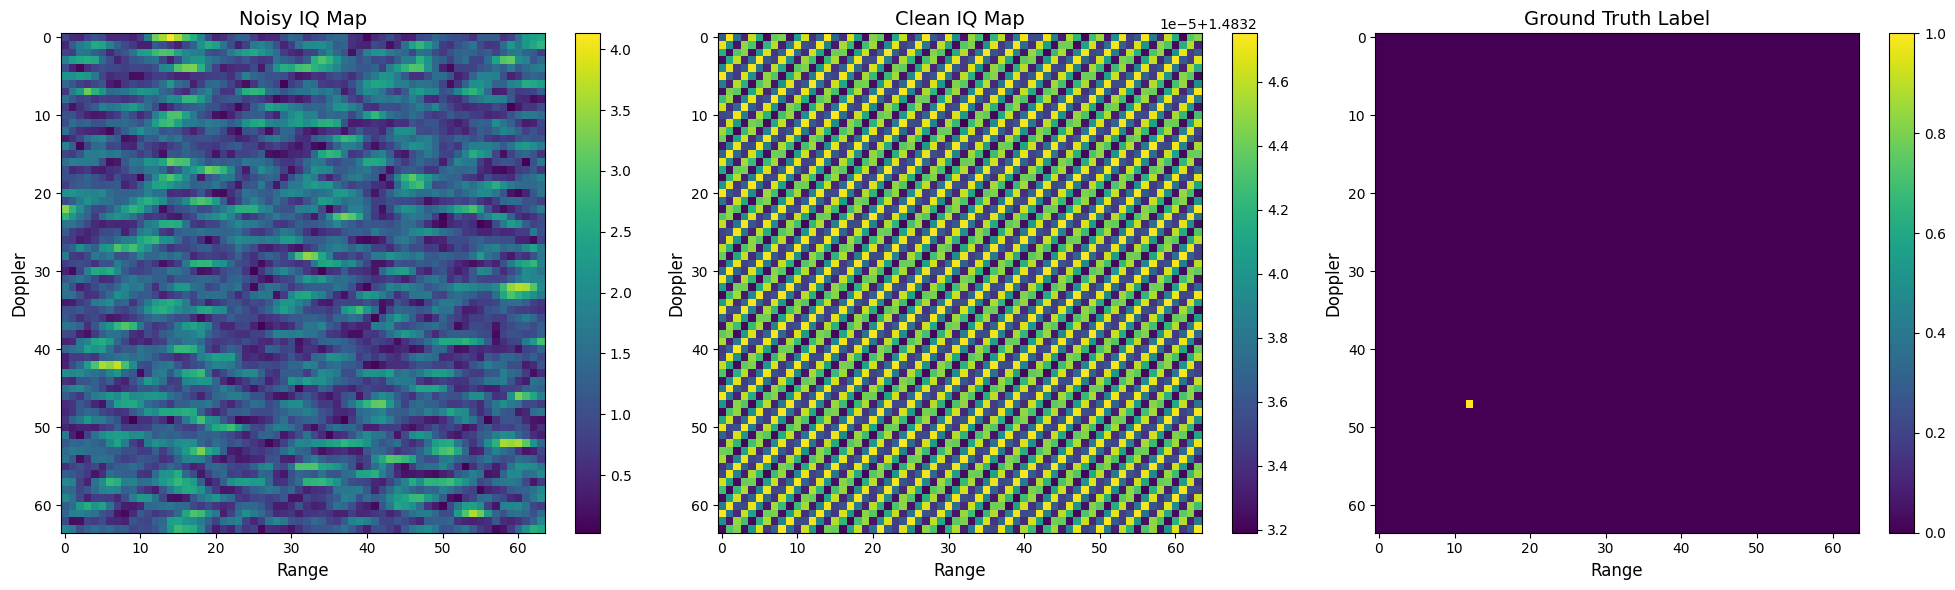

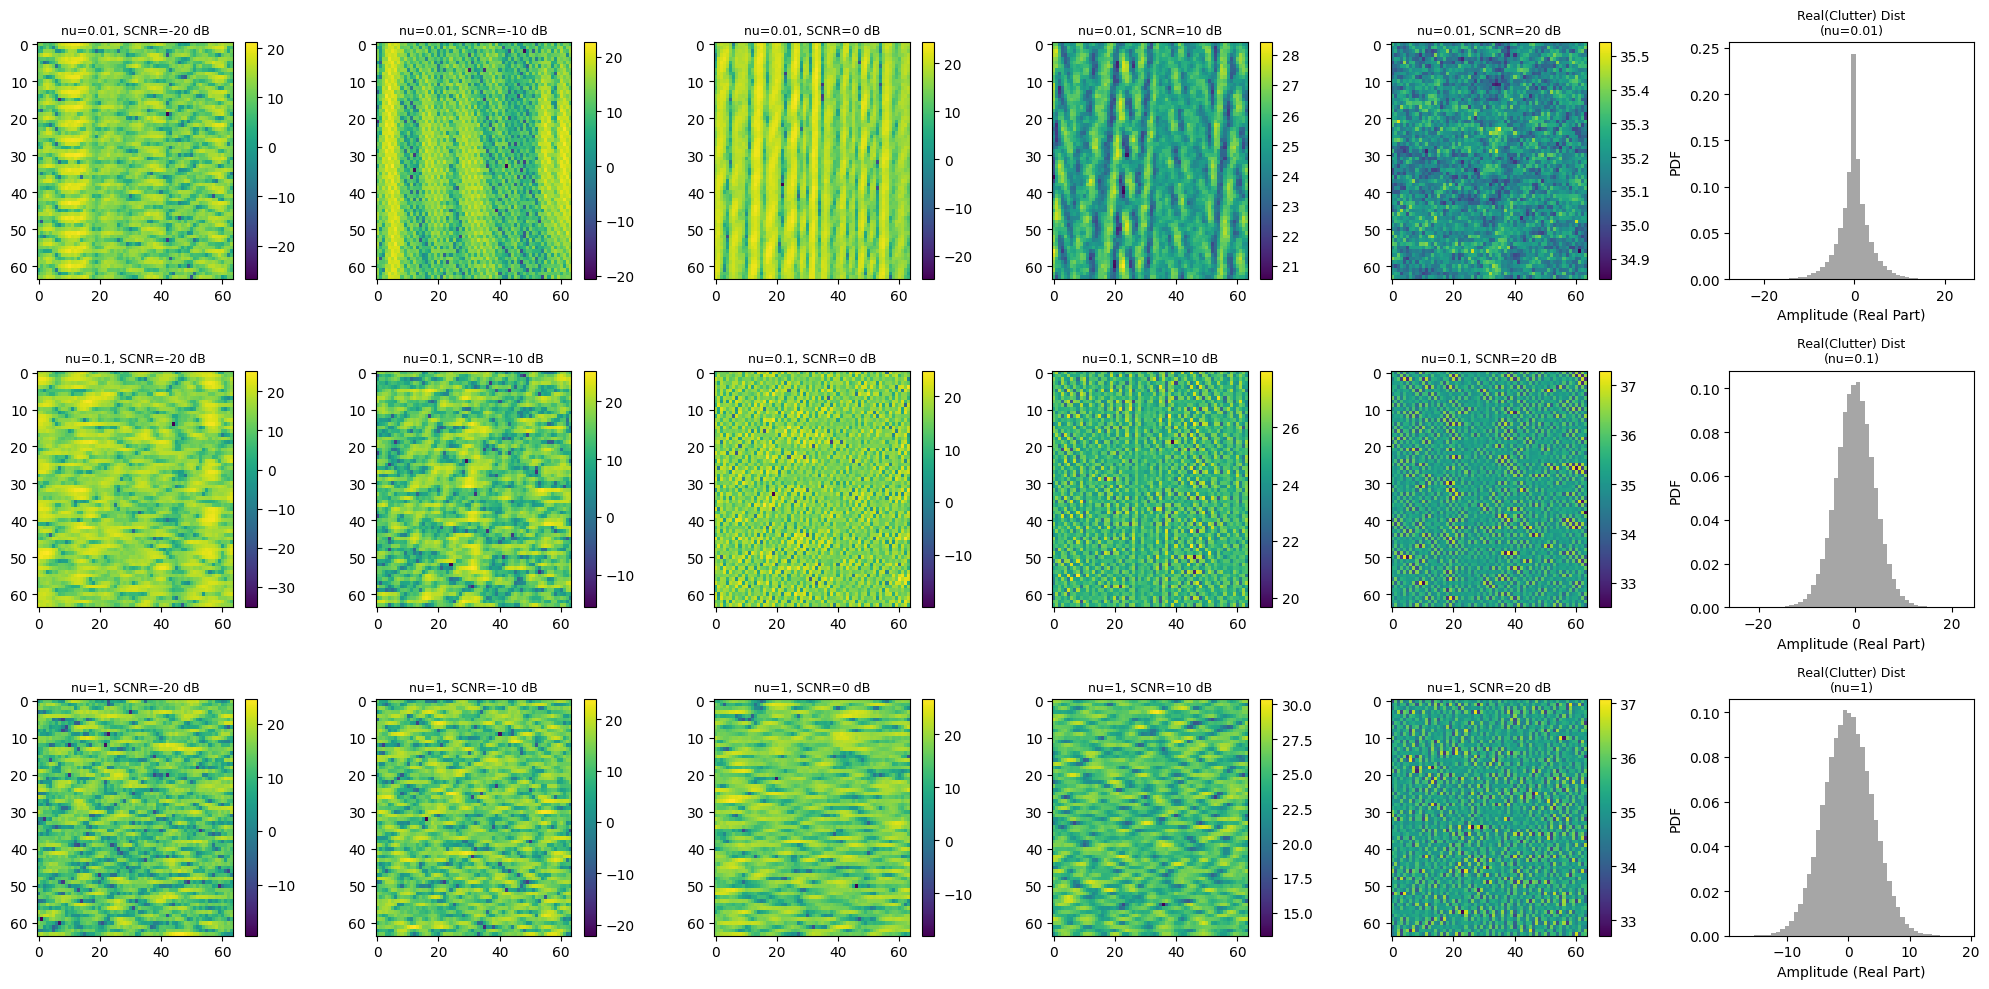

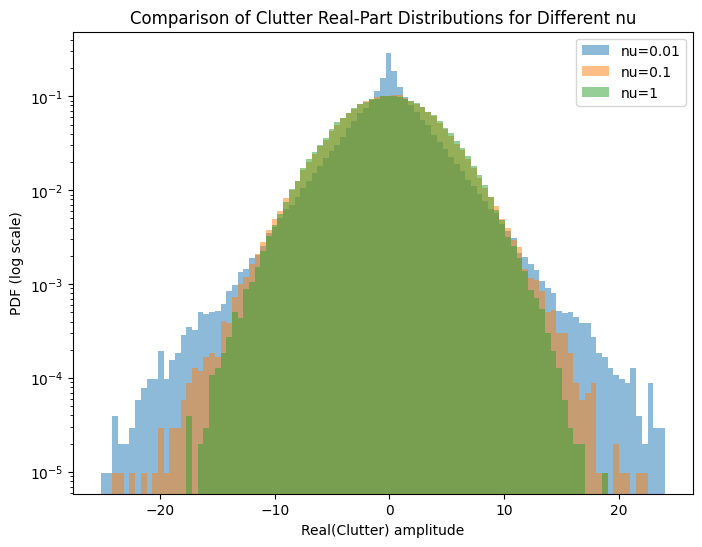

In [60]:
visualize_sample(train_dataset_with_targets, sample_index=1)
visualize_sample(norm_train_dataset, sample_index=1)
compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset)

## UNet Model

In [61]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)


In [62]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)

        # reshape to (B, num_heads, C//num_heads, H*W)
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) / math.sqrt(C // self.num_heads)
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return x + out


In [63]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)


In [64]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

In [65]:
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [66]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=32):
        """
        in_channels=4 because we concatenate:
            - x_t: the noised (or current reverse process) image (2 channels: real and imag)
            - cond: the conditioning (observed noisy) image (2 channels: real and imag)
        out_channels=2 since we predict noise for both the real and imaginary parts.
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Bottleneck with attention
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        self.atten1 = SelfAttention2d(128)
        self.atten2 = SelfAttention2d(256)
        # Decoder with time embedding injections
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Time embeddings injected at various stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,4,H,W) where channels are [x_t_real, x_t_imag, cond_real, cond_imag]
        t: (B,) normalized timesteps
        """
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

        x1 = self.inc(x)                 # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)
        x3_skip, x3 = self.down2(x2)       # (B,256,H,W)
        x4_skip, x4 = self.down3(x3)       # (B,256,H,W)
        
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)
        output = self.outc(x)
        return output




## Diffusion model

In [67]:
# class ConditionalDiffusion(nn.Module):
#     def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
#         super().__init__()
#         self.model = model  
#         self.T = T
#         self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
#         self.register_buffer("alphas", 1.0 - self.betas)
#         self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

#     def q_sample(self, x0, t, noise=None):
#         """
#         Forward diffusion: add noise to x0 at timestep t.
#         """
#         if noise is None:
#             noise = torch.randn_like(x0)
#         sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
#         sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
#         return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

#     def p_losses(self, x0, t, cond):
#         """
#         Loss: train network to predict the noise added.
#         x0: clean signal (B,2,H,W) with channels [real, imag]
#         cond: conditioning (observed noisy IQ) (B,2,H,W) with channels [real, imag]
#         """
#         x_noisy, noise = self.q_sample(x0, t)
#         t_norm = t.float() / self.T
        
#         # Concatenate along channel dimension: [x_noisy, cond] -> (B,4,H,W)
#         model_input = torch.cat([x_noisy, cond], dim=1)
#         noise_pred = self.model(model_input, t_norm)
#         return F.mse_loss(noise_pred, noise)

#     @torch.no_grad()
#     def p_sample(self, x, t, cond):
#         """
#         One reverse diffusion step (from x_t to x_{t-1}).
#         """
#         betas_t = self.betas[t].view(-1, 1, 1, 1)
#         alphas_t = self.alphas[t].view(-1, 1, 1, 1)
#         alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
#         t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

#         model_input = torch.cat([x, cond], dim=1)
#         noise_pred = self.model(model_input, t_norm)

#         coef1 = 1 / torch.sqrt(alphas_t)
#         coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
#         mean = coef1 * (x - coef2 * noise_pred)
        
#         noise = torch.randn_like(x) if t > 0 else 0
#         return mean + torch.sqrt(betas_t) * noise

#     @torch.no_grad()
#     def sample(self, cond, shape):
#         """
#         Generate a denoised signal conditioned on cond.
#         cond: (B,2,H,W) the observed noisy IQ (real and imaginary)
#         shape: desired shape of x (B,2,H,W)
#         """
#         x = torch.randn(shape, device=cond.device)
#         for t in reversed(range(self.T)):
#             t_tensor = torch.tensor([t], device=x.device)
#             x = self.p_sample(x, t_tensor, cond)
#         return x


In [68]:
class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, scheduler_type="cosine", beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model
        self.T = T

        if scheduler_type == "linear":
            betas = torch.linspace(beta_start, beta_end, T)
        elif scheduler_type == "cosine":
            # Following Nichol & Dhariwal (2021): "Improved Denoising Diffusion Probabilistic Models"
            s = 0.008
            timesteps = torch.linspace(0, T, T + 1) / T  # normalized [0,1]
            alphas_bar = torch.cos((timesteps + s) / (1 + s) * math.pi / 2) ** 2
            alphas_bar = alphas_bar / alphas_bar[0]  # normalize to start at 1
            # Compute betas from the discrete alpha_bar values
            betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
            betas = betas.clamp(max=0.999)  # avoid numerical issues
        else:
            raise ValueError(f"Unknown scheduler type: {scheduler_type}")
             
        # Register buffers for later use in the forward and reverse diffusion processes
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", 1.0 - betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Loss: train network to predict the noise added.
        x0: clean signal (B,2,H,W) with channels [real, imag]
        cond: conditioning (observed noisy IQ) (B,2,H,W) with channels [real, imag]
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        
        # Concatenate along channel dimension: [x_noisy, cond] -> (B,4,H,W)
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        One reverse diffusion step (from x_t to x_{t-1}).
        """
        # Ensure t is used as an integer for indexing and condition checks.
        t_int = t.item() if isinstance(t, torch.Tensor) else t

        betas_t = self.betas[t_int].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t_int].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t_int].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t_int], device=x.device).float() / self.T).repeat(x.shape[0])

        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        
        noise = torch.randn_like(x) if t_int > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised signal conditioned on cond.
        cond: (B,2,H,W) the observed noisy IQ (real and imaginary)
        shape: desired shape of x (B,2,H,W)
        """
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x


In [69]:
def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        # Unpack the tuple from your dataset.
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch

        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        # Concatenate to form 2-channel tensors.
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)   # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)

        # Sample random timesteps for diffusion.
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        
        # Compute loss.
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)


@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)
        
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()

        # For the first batch, generate a sample and compute metrics.
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

## Train

In [ ]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=2000, beta_start=1e-4, beta_end=0.05).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)
num_epochs = 2200
best_val_loss = float('inf')
best_mse_loss = float('inf')

train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), "new_diffusion.pth")
        print("   --> Best model saved.")

# 5. Plot training curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()


Epoch 1/2200: Train Loss = 0.5137 | Val Loss = 0.4483
   [Generation Metrics] MSE: 36715144.0000 | PSNR: -64.61 dB
   --> Best model saved.
Epoch 2/2200: Train Loss = 0.4303 | Val Loss = 0.4070
   [Generation Metrics] MSE: 18331766.0000 | PSNR: -61.59 dB
   --> Best model saved.
Epoch 3/2200: Train Loss = 0.3912 | Val Loss = 0.3714
   [Generation Metrics] MSE: 15102920.0000 | PSNR: -60.75 dB
   --> Best model saved.
Epoch 4/2200: Train Loss = 0.3531 | Val Loss = 0.3404
   [Generation Metrics] MSE: 14276189.0000 | PSNR: -60.50 dB
   --> Best model saved.
Epoch 5/2200: Train Loss = 0.3280 | Val Loss = 0.3200
   [Generation Metrics] MSE: 11331440.0000 | PSNR: -59.50 dB
   --> Best model saved.
Epoch 6/2200: Train Loss = 0.3063 | Val Loss = 0.2981
   [Generation Metrics] MSE: 9695990.0000 | PSNR: -58.82 dB
   --> Best model saved.
Epoch 7/2200: Train Loss = 0.2873 | Val Loss = 0.2731
   [Generation Metrics] MSE: 8702597.0000 | PSNR: -58.35 dB
   --> Best model saved.
Epoch 8/2200: Train Lo

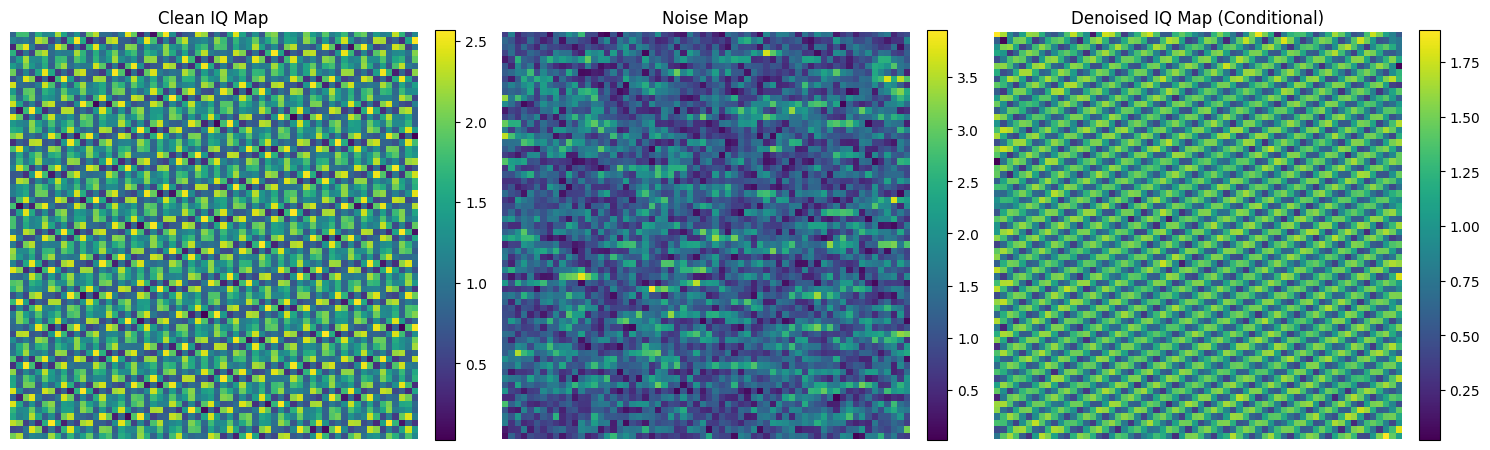

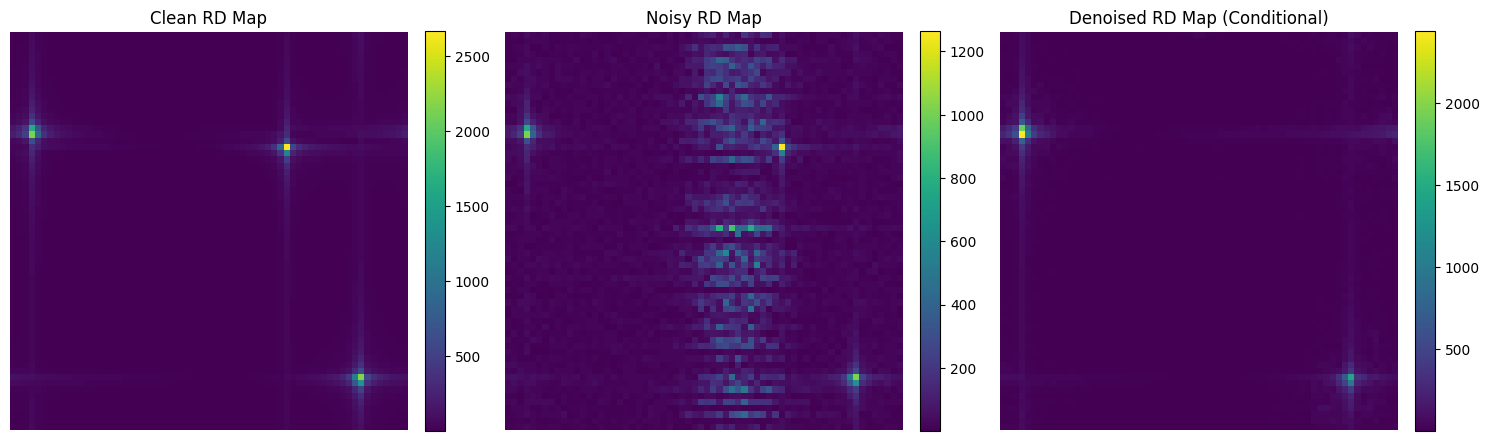

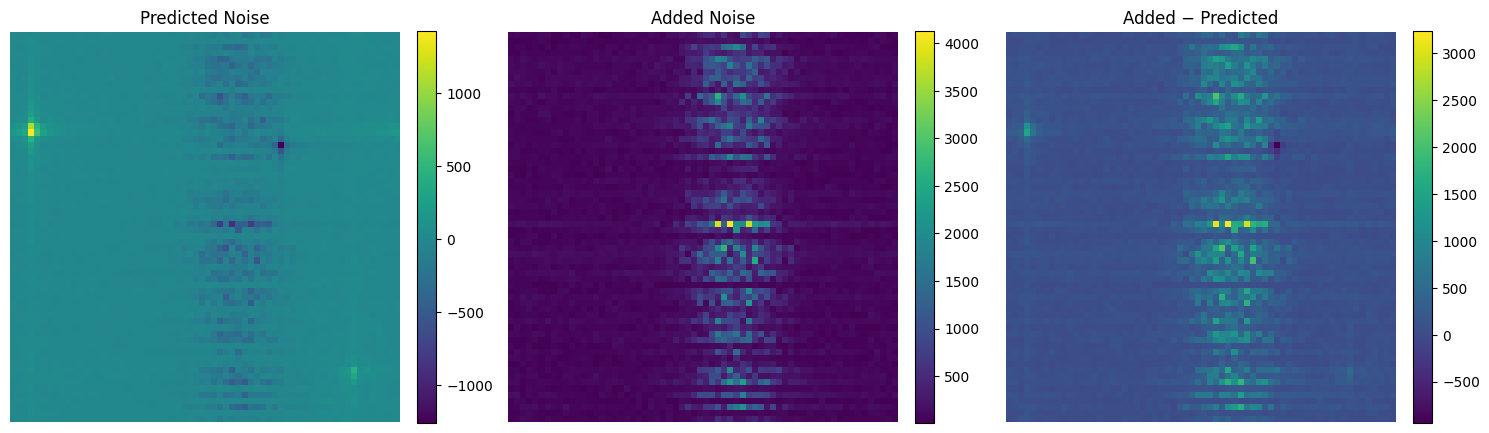

In [55]:
import random
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    # Ensure IQ_map is a tensor
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    # Convert IQ_map to a complex tensor if it's not already
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    dev = IQ_map.device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    
    # Compute the RD map using the Hermitian transpose for R
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    
    # Move the result to CPU for visualization
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference():

    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    # cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
    # cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # # 2. Load the saved best checkpoint
    checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/notebooks/first_working_diffusion.pth"
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    signal, C, W, IQ, _, _ =  norm_val_dataset[random.randint(1,1000)] #RadarDataset(num_samples=100, n_targets=8, random_n_targets=True,snr=30, cnr=15)[0],
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [signal, IQ, generated_complex.cpu()],
                            ["Clean IQ Map", "Noise Map", "Denoised IQ Map (Conditional)"]):
        im = ax.imshow(abs(img), cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [create_rd_map(signal), create_rd_map(IQ), create_rd_map(generated_complex)],
                            ["Clean RD Map", "Noisy RD Map", "Denoised RD Map (Conditional)"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [create_rd_map(generated_complex)-create_rd_map(IQ),
                            create_rd_map(C)+create_rd_map(W),
                            create_rd_map(C)+create_rd_map(W) - (create_rd_map(IQ)-create_rd_map(generated_complex))],
                            ["Predicted Noise", "Added Noise", "Added − Predicted"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

run_inference()


In [45]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    # Ensure IQ_map is a tensor
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    # Convert IQ_map to a complex tensor if it's not already
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    # Get the device of the IQ_map
    dev = IQ_map.device
    
    # Generate steering matrices on the same device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    
    # Compute the RD map using the Hermitian transpose for R
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    
    # Move the result to CPU for visualization
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference():

    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    # cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
    # cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # # 2. Load the saved best checkpoint
    # checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/notebooks/new_diffusion.pth"
    # cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    # 3. Get a sample from dataset (or use your own custom input)
    #    Here we assume the dataset returns a tuple where:
    #       element 0: clean signal (complex tensor)
    #       element 3: IQ (noisy measurement, complex tensor)
    signal, C, W, IQ, _, _ =  norm_val_dataset[0] #RadarDataset(num_samples=100, n_targets=8, random_n_targets=True,snr=30, cnr=15)[0]
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    
    # For visualization, use the original clean signal and IQ as complex images.
    # If they already are complex, no further conversion is needed.
    # (If needed, you can also combine two channels as done for generated_complex.)
    
    # 7. Visualization of RD maps

    # 1️⃣ IQ‑map visuals
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [signal, W+C, IQ - generated_complex.cpu()],
                            ["Clean IQ Map", "Noise Map", "Denoised IQ Map (Conditional)"]):
        im = ax.imshow(abs(img), cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # 2️⃣ Range‑Doppler maps
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [create_rd_map(signal), create_rd_map(IQ), create_rd_map(IQ)-create_rd_map(generated_complex)],
                            ["Clean RD Map", "Noisy RD Map", "Denoised RD Map (Conditional)"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # 3️⃣ Noise comparison
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [create_rd_map(generated_complex)-create_rd_map(IQ),
                            create_rd_map(C)+create_rd_map(W),
                            create_rd_map(C)+create_rd_map(W) - (create_rd_map(IQ)-create_rd_map(generated_complex))],
                            ["Predicted Noise", "Added Noise", "Added − Predicted"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()











    # fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    # axes[0].imshow(abs(signal), cmap='viridis')
    # axes[0].set_title("Clean IQ Map")
    # axes[0].axis("off")

    # axes[1].imshow(abs(W+C), cmap='viridis')
    # axes[1].set_title("Noisy IQ Map")
    # axes[1].axis("off")

    # axes[2].imshow(abs(IQ-generated_complex.cpu()), cmap='viridis')
    # axes[2].set_title("Denoised IQ Map (Conditional)")
    # axes[2].axis("off")

    # plt.tight_layout()
    # plt.show()

    # fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    # axes[0].imshow(create_rd_map(signal), cmap='viridis')
    # axes[0].set_title("Clean RD Map")
    # axes[0].axis("off")

    # axes[1].imshow(create_rd_map(IQ), cmap='viridis')
    # axes[1].set_title("Noisy RD Map")
    # axes[1].axis("off")

    # axes[2].imshow(create_rd_map(generated_complex), cmap='viridis')
    # axes[2].set_title("Denoised RD Map (Conditional)")
    # axes[2].axis("off")

    # plt.tight_layout()
    # plt.show()

    # fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    # axes[0].imshow(create_rd_map(generated_complex)-create_rd_map(IQ), cmap='viridis')
    # axes[0].set_title("Predicted Noise")
    # axes[0].axis("off")

    # axes[1].imshow(create_rd_map(C)+create_rd_map(W), cmap='viridis')
    # axes[1].set_title("Added Noise")
    # axes[1].axis("off")

    # axes[2].imshow(create_rd_map(C)+create_rd_map(W)-(create_rd_map(IQ)-create_rd_map(generated_complex)), cmap='viridis')
    # axes[2].set_title("added-predicted")
    # axes[2].axis("off")

    # plt.tight_layout()
    # plt.show()

run_inference()


KeyboardInterrupt: 